# Const

In [1]:
FOLDER = "images"

OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
TRAIN_DIR = f"{FOLDER}/train"

OLD_TEST_DIR = f"{FOLDER}/Конволюты"
TEST_DIR = f"{FOLDER}/test"

NEW_TRAIN_DIR = f"{FOLDER}/new_train"
NEW_TEST_DIR = f"{FOLDER}/new_test"
IMG_SIZE = (3024, 4032)

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8

# (3024, 4032) -> (x, 256)
# (3024 * 256 / 4032, 256)
# int(3024/4), int(4032/4)

# Библиотеки

In [ ]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 900_000_000

import random

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

# import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix as conf_matrix
import seaborn as sns

def open_image(image):
    # чтобы изображение не поворачивалось на 90 градусов, если w < h
    # https://stackoverflow.com/questions/4228530/pil-thumbnail-is-rotating-my-image
    img = Image.open(image)
    img = ImageOps.exif_transpose(img)
    return img

# https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size[0] - img.size[0]
    delta_height = desired_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail(expected_size)
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

# Папки train и test

In [ ]:
!rm -r "$FOLDER"

In [ ]:
!tree

.
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

0 directories, 3 files


In [ ]:
# извлекаем два zip в FOLDER
!unzip 'Жуковский образцы почерка.zip' -d "$FOLDER"
!unzip 'Конволюты.zip' -d "$FOLDER"

Archive:  Жуковский образцы почерка.zip
   creating: images/Жуковский образцы почерка/
  inflating: images/Жуковский образцы почерка/.DS_Store  
  inflating: images/__MACOSX/Жуковский образцы почерка/._.DS_Store  
   creating: images/Жуковский образцы почерка/1 Ранний почерк/
   creating: images/Жуковский образцы почерка/2 Зрелый почерк/
   creating: images/Жуковский образцы почерка/3 Поздний почерк/
   creating: images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Протасовым (хороший почерк). 1 апреля 1814. ИРЛИ. Р. 1. Оп. 9. № 83/
  inflating: images/Жуковский образцы почерка/1 Ранний почерк/.DS_Store  
  inflating: images/__MACOSX/Жуковский образцы почерка/1 Ранний почерк/._.DS_Store  
  inflating: images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.pdf  
  inflating: images/__MACOSX/Жуковский образцы почерка/1 Ранний почерк/._Жуковский к Тургеневу и Блудову (обы

In [ ]:
!rm -r "$FOLDER"/__MACOSX

In [ ]:
# удаление всех docx файлов (с расшифровкой почерков)
# https://recoverit.wondershare.com/file-recovery/linux-remove-directory-recursively.html
!find ./"$FOLDER" -type f -name '*.docx' -print -delete

./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.docx
./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676.docx
./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Плетневу и Вяземскому (плохой почерк). 1847. ИРЛИ. № 27763.docx
./images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.docx
./images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Протасовым (хороший почерк). 1 апреля 1814. ИРЛИ. Р. 1. Оп. 9. № 83.docx
./images/Жуковский образцы почерка/2 Зрелый почерк/Жуковский к Воейковой (обычный почерк). 1821. ИРЛИ. Р. 3. Оп. 1. № 1109.docx
./images/Жуковский образцы почерка/2 Зрелый почерк/Жуковский к неизвестному (Вяземскому? плохой почерк). Б.д. ИРЛИ. № 2882.docx
./images/Жуковский образцы п

In [ ]:
# удаление скрытых файлов
!find ./"$FOLDER" -type f -name '.*' -print -delete

./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/.DS_Store
./images/Жуковский образцы почерка/3 Поздний почерк/.DS_Store
./images/Жуковский образцы почерка/1 Ранний почерк/.DS_Store
./images/Жуковский образцы почерка/2 Зрелый почерк/.DS_Store
./images/Жуковский образцы почерка/.DS_Store
./images/Конволюты/.DS_Store


In [ ]:
!tree -L 2

.
├── images
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

3 directories, 3 files


In [ ]:
# перевод pdf файлов в jpg
for dirpath, dirnames, filenames in os.walk(FOLDER):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        root, ext = os.path.splitext(fname) # ('Жуковский (обычный почерк)', '.pdf')
        fpath = os.path.join(dirpath, fname)

        if ext in {".jpeg", ".JPG", ".jpg"}:
            continue
        elif ext == ".pdf":
            print(f"--- Сonversion of '{fname}' ---")
            print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")
            # !echo "$fname"
            !pdftoppm -jpeg -r 600 "$fpath" "$dirpath"/"$root"
            !du -h "$fpath"                 # размер старого файла
            !du -h "$dirpath"/"$root"-1.jpg # размер нового файла
            !rm "$fpath"
        else:
            print("!!!!!!!!!!!!")

        print("\n")

--- Сonversion of 'Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк',
dirnames = ['Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676', 'Жуковский к Плетневу и Вяземскому (плохой почерк). 1847. ИРЛИ. № 27763'],
filenames = ['Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf']

2,0M	images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf
5,2M	images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1-1.jpg


--- Сonversion of 'Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.pdf' ---
dirpath = 'images/Жуковский образцы почерка/1 Ранний почерк',
dirnames = ['Жуковский к Протасовым (хороший почерк). 1 апреля 18

In [ ]:
# есть в папке только файлы, то перенумеруем их

for dirpath, dirnames, filenames in os.walk(FOLDER):

    if len(dirnames) == 0: # если внутри нет папок
        for i, fname in enumerate(sorted(filenames)):
            _, ext = os.path.splitext(fname) # ('Жуковский (обычный почерк)', '.pdf')
            fpath = os.path.join(dirpath, fname)

            new_fpath = os.path.join(dirpath, str(i)) + ext

            print(f"--- Сonversion of '{fname}' to '{i}' ---")
            print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

            !mv "$fpath" "$new_fpath"

        print("\n")

--- Сonversion of 'eaa0291_001_0008676_00001.JPG' to '0' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'eaa0291_001_0008676_00005.JPG', 'eaa0291_001_0008676_00002.JPG', 'eaa0291_001_0008676_00004.JPG']

--- Сonversion of 'eaa0291_001_0008676_00002.JPG' to '1' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'eaa0291_001_0008676_00005.JPG', 'eaa0291_001_0008676_00002.JPG', 'eaa0291_001_0008676_00004.JPG']

--- Сonversion of 'eaa0291_001_0008676_00004.JPG' to '2' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'e

## train

In [ ]:
!rm -r "$TRAIN_DIR"

rm: cannot remove 'images/train': No such file or directory


In [ ]:
!mkdir "$TRAIN_DIR"

In [ ]:
# формирование train из "Жуковский образцы почерка" + переименование файлов

for dirpath, dirnames, filenames in os.walk(OLD_TRAIN_DIR):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        _, ext = os.path.splitext(fname)
        fpath = os.path.join(dirpath, fname)

        # print(f"\n{dirpath = },\n{dirnames = },\n{filenames = },\n{fpath = }")

        splitpath = re.split(r"/", fpath)
        # ['data', 'Жуковский образцы почерка', '3 Поздний почерк', 'Жуковский (обычный почерк).jpg']
        splitpath[-1] = os.path.splitext(splitpath[-1])[0]
        # ['data', 'Жуковский образцы почерка', '3 Поздний почерк', 'Жуковский (обычный почерк)']

        for i, elem in enumerate(splitpath):
            inx_left_bracket = elem.find("(")
            inx_right_bracket = elem.rfind(")")

            if (inx_left_bracket != -1) and (inx_right_bracket != -1):
                splitpath[i] = elem[inx_left_bracket : inx_right_bracket + 1]

        new_fpath = os.path.join(TRAIN_DIR, "-".join(splitpath[2:])) + ext

        print(f"--- Copying of\n{fpath}\nto\n{new_fpath}\n---")

        !cp "$fpath" "$new_fpath"

--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1-1.jpg
to
images/train/3 Поздний почерк-(обычный почерк).jpg
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/1.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-1.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/2.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-2.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/0.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-0.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 

## test

In [ ]:
!rm -r "$TEST_DIR"

rm: cannot remove 'images/test': No such file or directory


In [ ]:
!mkdir "$TEST_DIR"

In [ ]:
# формирование test из "Конволюты" + переименование файлов

for dirpath, dirnames, filenames in os.walk(OLD_TEST_DIR):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        _, ext = os.path.splitext(fname)
        fpath = os.path.join(dirpath, fname)

        splitpath = re.split(r"/", fpath)
        # ['data', 'Конволюты', 'РГИА. Ф. 472. Оп. 1. № 662. О жалованье', '4.JPG']
        splitpath[-1] = os.path.splitext(splitpath[-1])[0]
        # ['data', 'Конволюты', 'РГИА. Ф. 472. Оп. 1. № 662. О жалованье', '4']

        # print(f"\n{fpath = },\n{splitpath = }\n")

        for i, elem in enumerate(splitpath):
            inx_left = elem.find("№")
            inx_right = elem.find(".", inx_left)
            inx_right_new = elem.find(" ", inx_left + 2) # РГИА. Ф. 722. Оп. 1. № 2013 О С5/27

            if inx_right == -1 or inx_right_new < inx_right:
                inx_right = inx_right_new

            if (inx_left != -1) and (inx_right != -1):
                splitpath[i] = elem[inx_left+2 : inx_right]

        new_fpath = os.path.join(TEST_DIR, "-".join(splitpath[2:])) + ext

        print(f"--- Copying of\n{fpath}\nto\n{new_fpath}\n---")

        !cp "$fpath" "$new_fpath"

--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/4.JPG
to
images/test/662-4.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/1.JPG
to
images/test/662-1.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/2.JPG
to
images/test/662-2.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/6.JPG
to
images/test/662-6.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/0.JPG
to
images/test/662-0.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/8.JPG
to
images/test/662-8.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/5.JPG
to
images/test/662-5.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/3.JPG
to
images/test/662-3.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/7.JPG
to
images/test/662-7.JPG
---
--- Copying of
images/Конволюты/РГИА.

## new_train (resize train)

In [ ]:
!tree -L 2

.
├── images
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

5 directories, 3 files


In [ ]:
!rm -r "$NEW_TRAIN_DIR"

rm: cannot remove 'images/new_train': No such file or directory


In [ ]:
!mkdir "$NEW_TRAIN_DIR"

In [ ]:
train_files = sorted(os.listdir(path=TRAIN_DIR))
test_files = sorted(os.listdir(path=TEST_DIR))

In [ ]:
for name in train_files[:5]:
    img = open_image(os.path.join(TRAIN_DIR, name))
    w, h = img.size
    print(f"{name:60} - {w} x {h}")

1 Ранний почерк-(обычный почерк).jpg                       - 21334 x 10242
1 Ранний почерк-(хороший почерк)-0.jpg                     - 1962 x 1169
1 Ранний почерк-(хороший почерк)-1.jpg                     - 2274 x 2941
1 Ранний почерк-(хороший почерк)-2.jpg                     - 2274 x 2941
1 Ранний почерк-(хороший почерк)-3.jpg                     - 2286 x 1564


In [ ]:
for name in test_files[:5]:
    img = open_image(os.path.join(TEST_DIR, name))
    w, h = img.size
    print(f"{name:13} - {w} x {h}")

122-0.JPG     - 3024 x 4032
122-1.JPG     - 3024 x 4032
122-10.JPG    - 3024 x 4032
122-11.JPG    - 3024 x 4032
122-2.JPG     - 3024 x 4032


In [ ]:
# thumbnail в папку NEW_TRAIN_DIR (с сохранением пропорции)
for i, name in enumerate(train_files):
    img = open_image(os.path.join(TRAIN_DIR, name))
    size_old = img.size

    if min(size_old) > 10000:
        # img = resize_with_padding(img, IMG_SIZE)
        img.thumbnail(IMG_SIZE)

    img.save(os.path.join(NEW_TRAIN_DIR, name))

    print(f"{i:2} - {size_old} \t-> {img.size}")

 0 - (21334, 10242) 	-> (3024, 1452)
 1 - (1962, 1169) 	-> (1962, 1169)
 2 - (2274, 2941) 	-> (2274, 2941)
 3 - (2274, 2941) 	-> (2274, 2941)
 4 - (2286, 1564) 	-> (2286, 1564)
 5 - (854, 625) 	-> (854, 625)
 6 - (1052, 1165) 	-> (1052, 1165)
 7 - (1440, 869) 	-> (1440, 869)
 8 - (1440, 853) 	-> (1440, 853)
 9 - (1440, 1671) 	-> (1440, 1671)
10 - (1440, 858) 	-> (1440, 858)
11 - (1904, 2601) 	-> (1904, 2601)
12 - (2152, 1448) 	-> (2152, 1448)
13 - (2293, 1598) 	-> (2293, 1598)
14 - (1607, 2488) 	-> (1607, 2488)
15 - (21334, 10325) 	-> (3024, 1464)
16 - (3992, 3156) 	-> (3992, 3156)
17 - (3992, 3156) 	-> (3992, 3156)
18 - (3992, 3156) 	-> (3992, 3156)
19 - (2214, 3683) 	-> (2214, 3683)
20 - (5616, 3744) 	-> (5616, 3744)
21 - (5616, 3744) 	-> (5616, 3744)
22 - (5616, 3744) 	-> (5616, 3744)


In [ ]:
# img = open_image(os.path.join(TRAIN_DIR, train_files[5]))
# print(img.size)
# img
# width, height = im.size
# im = im.resize((100, 300))
# im

In [ ]:
# img.thumbnail((1000, 1000))
# print(img.size)
# img

## new_test (resize test)

In [ ]:
!tree -L 2

.
├── images
│   ├── new_train
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

6 directories, 3 files


In [ ]:
!rm -r "$NEW_TEST_DIR"

rm: cannot remove 'images/new_test': No such file or directory


In [ ]:
!mkdir "$NEW_TEST_DIR"

In [ ]:
# копируем в папку NEW_TEST_DIR
for name in test_files:
    img = open_image(os.path.join(TEST_DIR, name))
    size_old = img.size
    # img = resize_with_padding(img, IMG_SIZE)

    img.save(os.path.join(NEW_TEST_DIR, name))

    # print(f"{size_old} \t-> {img.size}")

## data

In [ ]:
!rm -r "$DATA"

rm: cannot remove 'data': No such file or directory


In [ ]:
! mkdir "$DATA"

In [ ]:
!cp -r "$NEW_TRAIN_DIR" "$DATA_POS"

In [ ]:
!cp -r "$NEW_TEST_DIR" "$DATA_NEG"

In [ ]:
!tree -L 2

.
├── data
│   ├── 0
│   └── 1
├── images
│   ├── new_test
│   ├── new_train
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

10 directories, 3 files


## Crop pos image (вручную)

In [ ]:
files_names = sorted(os.listdir(DATA_POS))
image_paths = [os.path.join(DATA_POS, i) for i in files_names]
for i, im in enumerate(image_paths):
    size = np.asarray(Image.open(im)).shape
    print(f"{i:2} - {files_names[i]:60} - {size}")

 0 - 1 Ранний почерк-(обычный почерк).jpg                       - (1452, 2200, 3)
 1 - 1 Ранний почерк-(хороший почерк)-0.jpg                     - (1169, 1962, 3)
 2 - 1 Ранний почерк-(хороший почерк)-1.jpg                     - (2941, 2274, 3)
 3 - 1 Ранний почерк-(хороший почерк)-2.jpg                     - (2941, 2274, 3)
 4 - 1 Ранний почерк-(хороший почерк)-3.jpg                     - (1564, 2286, 3)
 5 - 2 Зрелый почерк-(Вяземскому? плохой почерк)-0.jpg          - (625, 854, 3)
 6 - 2 Зрелый почерк-(Вяземскому? плохой почерк)-1.jpg          - (1165, 1052, 3)
 7 - 2 Зрелый почерк-(идеальный почерк)-0.jpeg                  - (869, 1440, 3)
 8 - 2 Зрелый почерк-(идеальный почерк)-1.jpeg                  - (853, 1440, 3)
 9 - 2 Зрелый почерк-(идеальный почерк)-2.jpeg                  - (1671, 1440, 3)
10 - 2 Зрелый почерк-(идеальный почерк)-3.jpeg                  - (858, 800, 3)
11 - 2 Зрелый почерк-(обычный почерк)-0.jpg                     - (2601, 1904, 3

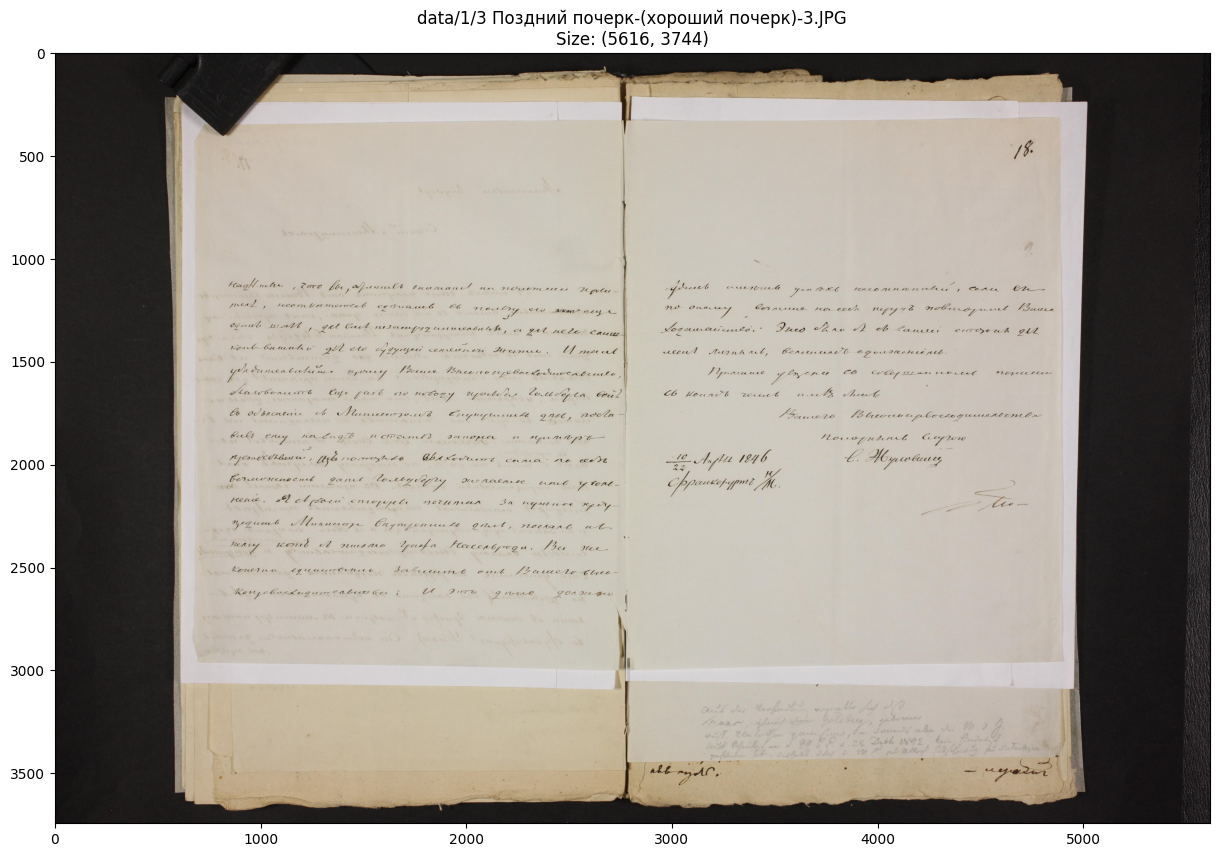

In [ ]:
# 0, 10, 15, 19, 20, 21, 22 картинки обрезала
image_path = image_paths[22]

# for image_path in image_paths:
im = Image.open(image_path)
plt.figure(figsize=(15, 10))
plt.title(f"{image_path}\nSize: {im.size}")
plt.imshow(im)
plt.show()

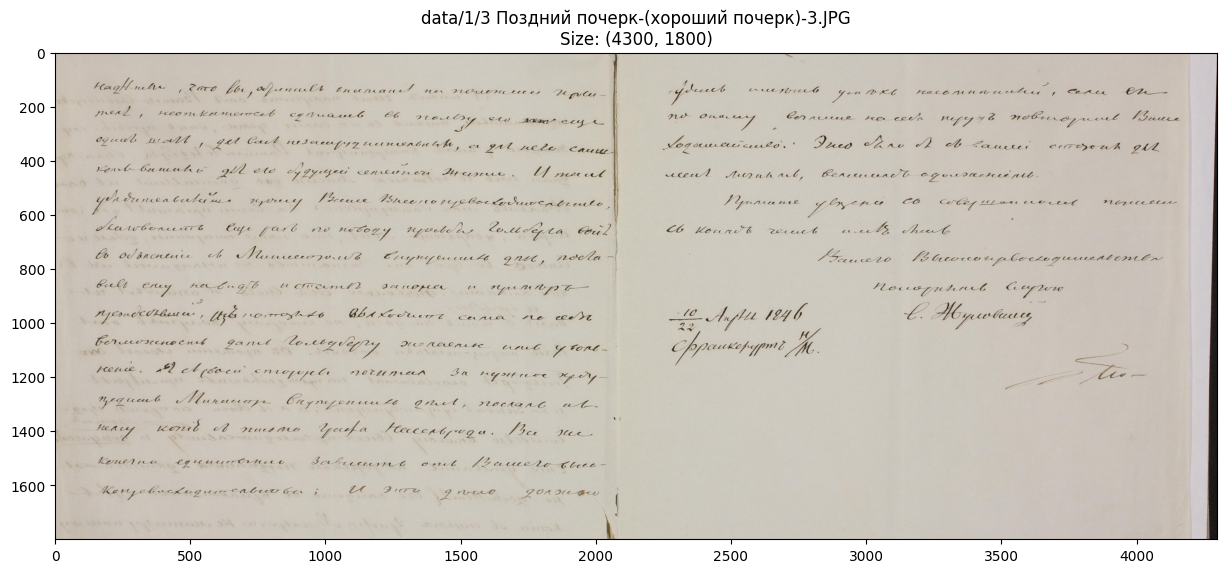

In [ ]:
width, height = im.size
left = 700
right = 5000
top, bottom = 1000, 2800
im1 = im.crop((left, top, right, bottom))
plt.figure(figsize=(15, 10))
plt.title(f"{image_path}\nSize: {im1.size}")
plt.imshow(im1)
plt.show()

In [ ]:
im1.save(image_path)

## Resize pos и neg

In [ ]:
!rm -r "$DATA_POS"

In [ ]:
# папка pos - копия ручной обрезки файлов из DATA_POS
!cp -r pos "$DATA_POS"

In [ ]:
# thumbnail для картинок из DATA_POS и DATA_NEG
files_names1 = sorted(os.listdir(DATA_POS))
files_names2 = sorted(os.listdir(DATA_NEG))

image_paths  = [os.path.join(DATA_POS, i) for i in files_names1]
image_paths += [os.path.join(DATA_NEG, i) for i in files_names2]

for i, image_path in enumerate(image_paths):
    img = open_image(image_path)
    size_old = img.size

    img.thumbnail((1000, 1000))

    img.save(image_path)

    if i < 25:
        print(f"{i:3} - {size_old} \t-> {img.size}")

  0 - (2200, 1452) 	-> (1000, 660)
  1 - (1962, 1169) 	-> (1000, 596)
  2 - (2274, 2941) 	-> (773, 1000)
  3 - (2274, 2941) 	-> (773, 1000)
  4 - (2286, 1564) 	-> (1000, 684)
  5 - (854, 625) 	-> (854, 625)
  6 - (1052, 1165) 	-> (903, 1000)
  7 - (1440, 869) 	-> (1000, 603)
  8 - (1440, 853) 	-> (1000, 592)
  9 - (1440, 1671) 	-> (862, 1000)
 10 - (800, 858) 	-> (800, 858)
 11 - (1904, 2601) 	-> (732, 1000)
 12 - (2152, 1448) 	-> (1000, 673)
 13 - (2293, 1598) 	-> (1000, 697)
 14 - (1607, 2488) 	-> (646, 1000)
 15 - (2000, 1464) 	-> (1000, 732)
 16 - (3992, 3156) 	-> (1000, 791)
 17 - (3992, 3156) 	-> (1000, 791)
 18 - (3992, 3156) 	-> (1000, 791)
 19 - (2214, 2500) 	-> (886, 1000)
 20 - (4300, 2300) 	-> (1000, 535)
 21 - (4000, 2800) 	-> (1000, 700)
 22 - (4300, 1800) 	-> (1000, 419)
 23 - (3024, 4032) 	-> (750, 1000)
 24 - (3024, 4032) 	-> (750, 1000)


In [ ]:
# for i, image_path in enumerate(image_paths):
#     img = open_image(image_path)

#     if i < 30:
#         print(f"{i:3} - {img.size}")